In [ ]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from functools import partial

from numba import vectorize, float64, guvectorize, njit

import time
import math
from tqdm import tqdm
import sklearn.mixture
import pandas as pd
import matplotlib.pyplot as plt

from jax.scipy.stats import multivariate_normal

In [ ]:
key = random.PRNGKey(68)
key1 = random.PRNGKey(6898)
key2 = random.PRNGKey(681998)
subkeys = random.split(key, 5000)

In [ ]:
# Generate data from stable distribution
@partial(jit, static_argnames=['dataset_size','num_datasets'])
def alpha_stable(alpha, beta, gamma, delta, dataset_size, num_datasets):
    # V = jnp.pi / 2 * (2 * random.uniform(key, shape = (num_datasets, dataset_size)) - 1)
    # W = - jnp.log(random.uniform(key1, shape = (num_datasets, dataset_size)))

    V = jnp.pi / 2 * (2 * jnp.array(np.random.rand(num_datasets, dataset_size)) - 1)
    W = - jnp.log(jnp.array(np.random.rand(num_datasets, dataset_size)))

    const = beta * jnp.tan(jnp.pi * alpha / 2)
    r1 = gamma * (((1 + const * const)**(1 / (2 * alpha))) * jnp.sin(alpha * V + jnp.arctan(const)) / ((jnp.cos(V)) ** (1/alpha)) * (( jnp.cos( (1-alpha) * V - jnp.arctan(const)) / W )**((1-alpha)/alpha))) + delta

    r_immi = 2 / jnp.pi * ((jnp.pi / 2 + beta * V) * jnp.tan(V) - beta * jnp.log( (jnp.pi / 2 * W * jnp.cos(V) ) / (jnp.pi / 2 + beta * V) ))
    r2 = gamma * r_immi + (2 / jnp.pi) * beta * gamma * jnp.log(gamma) + delta
    return jnp.where(alpha !=1, r1, r2)

In [ ]:
true_theta = jnp.array([1.8, 0.5, 1, 0])

In [ ]:
actual_data = alpha_stable(true_theta[0], true_theta[1], true_theta[2], true_theta[3], 200, 1)
actual_data

Array([[-6.51023090e-01,  2.80316496e+00, -5.65799296e-01,
         1.13667119e+00, -2.49493480e+00,  1.52471334e-01,
        -2.86155224e+00, -6.51684552e-02,  9.89797711e-02,
         2.03409338e+00, -1.81722307e+00,  8.77892494e-01,
        -8.78433585e-02, -6.24450505e-01,  5.24822414e-01,
         1.22712064e+00,  3.26611591e-03,  1.76315367e+00,
        -8.78052890e-01, -1.58867621e+00,  2.47820497e+00,
        -5.82996666e-01, -7.45392561e-01, -7.06632912e-01,
         9.66144875e-02,  8.10592234e-01,  7.59961486e-01,
        -1.07780826e+00, -8.90909970e-01,  8.83660197e-01,
         1.55529892e+00, -6.06026363e+00, -9.70722139e-02,
         1.46112079e-03, -9.77768540e-01, -1.34737086e+00,
        -2.19173884e+00,  4.56586391e-01,  6.48674607e-01,
        -1.71806109e+00, -1.10160661e+00,  1.52150735e-01,
        -4.10445184e-01,  2.99996042e+00, -1.99285102e+00,
        -1.59662807e+00,  1.63915980e+00, -3.01410556e+00,
         1.11522794e+00, -4.15791452e-01,  1.15523958e+0

In [ ]:
# CALCULATE SUMMARY STATS
@jit
def alpha_stable_ss(data):
  # Compute quantile statistics
  v_stability = (jnp.percentile(data, 95) - jnp.percentile(data, 5)) / (jnp.percentile(data, 75) - jnp.percentile(data, 25))
  v_skewness = (jnp.percentile(data, 95) + jnp.percentile(data, 5) - 2 * jnp.percentile(data, 50)) / (jnp.percentile(data, 95) - jnp.percentile(data, 5))
  v_scale = (jnp.percentile(data, 75) - jnp.percentile(data, 25)) / 1
  v_loc = jnp.mean(data)

  # Define interpolation matrices (see [1])
  tv_stability = jnp.array([2.439, 2.5, 2.6, 2.7, 2.8, 3.0, 3.2, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 25.0])
  tv_skewness = jnp.array([0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
  t_stability = jnp.array([2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5])
  t_skewness = jnp.array([0.0, 0.25, 0.5, 0.75, 1.0])

  psi1 = jnp.array([[2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000],
    [1.916, 1.924, 1.924, 1.924, 1.924, 1.924, 1.924],
    [1.808, 1.813, 1.829, 1.829, 1.829, 1.829, 1.829],
    [1.729, 1.730, 1.737, 1.745, 1.745, 1.745, 1.745],
    [1.664, 1.663, 1.663, 1.668, 1.676, 1.676, 1.676],
    [1.563, 1.560, 1.553, 1.548, 1.547, 1.547, 1.547],
    [1.484, 1.480, 1.471, 1.460, 1.448, 1.438, 1.438],
    [1.391, 1.386, 1.378, 1.364, 1.337, 1.318, 1.318],
    [1.279, 1.273, 1.266, 1.250, 1.210, 1.184, 1.150],
    [1.128, 1.121, 1.114, 1.101, 1.067, 1.027, 0.973],
    [1.029, 1.021, 1.014, 1.004, 0.974, 0.935, 0.874],
    [0.896, 0.892, 0.887, 0.883, 0.855, 0.823, 0.769],
    [0.818, 0.812, 0.806, 0.801, 0.780, 0.756, 0.691],
    [0.698, 0.695, 0.692, 0.689, 0.676, 0.656, 0.595],
    [0.593, 0.590, 0.588, 0.586, 0.579, 0.563, 0.513]])

  psi2 = jnp.array([[0.000, 2.160, 1.000, 1.000, 1.000, 1.000, 1.000],
    [0.000, 1.592, 3.390, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.759, 1.800, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.482, 1.048, 1.694, 1.000, 1.000, 1.000],
    [0.000, 0.360, 0.760, 1.232, 2.229, 1.000, 1.000],
    [0.000, 0.253, 0.518, 0.823, 1.575, 1.000, 1.000],
    [0.000, 0.203, 0.410, 0.632, 1.244, 1.906, 1.000],
    [0.000, 0.165, 0.332, 0.499, 0.943, 1.560, 1.000],
    [0.000, 0.136, 0.271, 0.404, 0.689, 1.230, 2.195],
    [0.000, 0.109, 0.216, 0.323, 0.539, 0.827, 1.917],
    [0.000, 0.096, 0.190, 0.284, 0.472, 0.693, 1.759],
    [0.000, 0.082, 0.163, 0.243, 0.412, 0.601, 1.596],
    [0.000, 0.074, 0.147, 0.220, 0.377, 0.546, 1.482],
    [0.000, 0.064, 0.128, 0.191, 0.330, 0.478, 1.362],
    [0.000, 0.056, 0.112, 0.167, 0.285, 0.428, 1.274]])

  psi3 = jnp.array([[1.908, 1.908, 1.908, 1.908, 1.908],
    [1.914, 1.915, 1.916, 1.918, 1.921],
    [1.921, 1.922, 1.927, 1.936, 1.947],
    [1.927, 1.930, 1.943, 1.961, 1.987],
    [1.933, 1.940, 1.962, 1.997, 2.043],
    [1.939, 1.952, 1.988, 2.045, 2.116],
    [1.946, 1.967, 2.022, 2.106, 2.211],
    [1.955, 1.984, 2.067, 2.188, 2.333],
    [1.965, 2.007, 2.125, 2.294, 2.491],
    [1.980, 2.040, 2.205, 2.435, 2.696],
    [2.000, 2.085, 2.311, 2.624, 2.973],
    [2.040, 2.149, 2.461, 2.886, 3.356],
    [2.098, 2.244, 2.676, 3.265, 3.912],
    [2.189, 2.392, 3.004, 3.844, 4.775],
    [2.337, 2.635, 3.542, 4.808, 6.247],
    [2.588, 3.073, 4.534, 6.636, 9.144]])


  psi4 = jnp.array([[0.0,    0.0,    0.0,    0.0,  0.0],
    [0.0, -0.017, -0.032, -0.049, -0.064],
    [0.0, -0.030, -0.061, -0.092, -0.123],
    [0.0, -0.043, -0.088, -0.132, -0.179],
    [0.0, -0.056, -0.111, -0.170, -0.232],
    [0.0, -0.066, -0.134, -0.206, -0.283],
    [0.0, -0.075, -0.154, -0.241, -0.335],
    [0.0, -0.084, -0.173, -0.276, -0.390],
    [0.0, -0.090, -0.192, -0.310, -0.447],
    [0.0, -0.095, -0.208, -0.346, -0.508],
    [0.0, -0.098, -0.223, -0.383, -0.576],
    [0.0, -0.099, -0.237, -0.424, -0.652],
    [0.0, -0.096, -0.250, -0.469, -0.742],
    [0.0, -0.089, -0.262, -0.520, -0.853],
    [0.0, -0.078, -0.272, -0.581, -0.997],
    [0.0, -0.061, -0.279, -0.659, -1.198]])

  tv_stability_i1 = jnp.max(jnp.append(0, jnp.argwhere(tv_stability <= v_stability, size=len(tv_stability), fill_value=0)))
  tv_stability_i2 = jnp.min(jnp.append(14, jnp.argwhere(tv_stability >= v_stability, size=len(tv_stability), fill_value=14)))
  tv_skewness_i1 = jnp.max(jnp.append(0, jnp.argwhere(tv_skewness <= jnp.abs(v_skewness), size=len(tv_skewness), fill_value=0)))
  tv_skewness_i2 = jnp.min(jnp.append(6, jnp.argwhere(tv_skewness >= jnp.abs(v_skewness), size=len(tv_skewness), fill_value=6)))

  dist_stability_tv = tv_stability[tv_stability_i2] - tv_stability[tv_stability_i1]

  dist_stability = jnp.where(dist_stability_tv != 0, (v_stability - tv_stability[tv_stability_i1]) / dist_stability_tv, dist_stability_tv)

  dist_skewness_tv = tv_skewness[tv_skewness_i2] - tv_skewness[tv_skewness_i1]

  dist_skewness = jnp.where(dist_skewness_tv != 0, (jnp.abs(v_skewness) - tv_skewness[tv_skewness_i1]) / dist_skewness_tv, dist_skewness_tv)

  psi1b1 = dist_stability*psi1[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i1]
  psi1b2 = dist_stability*psi1[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i2]
  alpha = dist_skewness*psi1b2+(1-dist_skewness)*psi1b1
  psi2b1 = dist_stability*psi2[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i1]
  psi2b2 = dist_stability*psi2[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i2]
  beta = jnp.sign(v_skewness)*(dist_skewness*psi2b2+(1-dist_skewness)*psi2b1)
  t_stability_i1 = jnp.max(jnp.append(0, jnp.argwhere(t_stability >= alpha, size=len(t_stability), fill_value=0)))
  t_stability_i2 = jnp.min(jnp.append(15, jnp.argwhere(t_stability <= alpha, size=len(t_stability), fill_value=15)))
  t_skewness_i1 = jnp.max(jnp.append(0, jnp.argwhere(t_skewness <= jnp.abs(beta),size=len(t_skewness), fill_value=0)))
  t_skewness_i2 = jnp.min(jnp.append(4, jnp.argwhere(t_skewness >= jnp.abs(beta),size=len(t_skewness), fill_value=4)))

  dist_stability_t = t_stability[t_stability_i2] - t_stability[t_stability_i1]

  dist_stability = jnp.where(dist_stability_t != 0, (alpha - t_stability[t_stability_i1]) / dist_stability_t, dist_stability_t)

  dist_skewness_t = t_skewness[t_skewness_i2] - t_skewness[t_skewness_i1]

  dist_skewness = jnp.where(dist_skewness_t != 0, (jnp.abs(beta) - t_skewness[t_skewness_i1]) / dist_skewness, dist_skewness_t)

  psi3b1 = dist_stability*psi3[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i1]
  psi3b2 = dist_stability*psi3[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i2]
  sigma = v_scale/(dist_skewness*psi3b2+(1-dist_skewness)*psi3b1)
  psi4b1 = dist_stability*psi4[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i1]
  psi4b2 = dist_stability*psi4[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i2]
  zeta = jnp.sign(beta)*sigma*(dist_skewness*psi4b2+(1-dist_skewness)*psi4b1) + jnp.percentile(data, 50)

  mu = jnp.where(jnp.abs(alpha-1) < 0.05, zeta, zeta - beta * sigma * jnp.tan(0.5 * jnp.pi *alpha))

  return jnp.array([alpha, beta, sigma, mu]) #stability, skewness, scale, loc

In [ ]:
actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics

Array([ 2.        ,  1.7160022 ,  1.0692402 , -0.15677758], dtype=float32)

In [ ]:
num_coeffs = 4
n_samples = 200
num_datasets = 200
lambda_dim = num_coeffs + int((num_coeffs * (num_coeffs + 1)) / 2)
tau = 0.01

In [ ]:
def my_inv(x):
    return jnp.linalg.inv(x + (jnp.eye(x.shape[0]) * 1e-7))

## Training Wasserstein Gaussianing

In [ ]:
def radial_flow(Lambda, x):
    # original_x = x
    d_Lambda = 2 + num_coeffs
    logdet_jacob_T_x = 0
    for k in range(num_layers):
        # print(k)
        Lambda_k = Lambda[k * d_Lambda : (k + 1) * d_Lambda]
        alpha = jnp.exp(Lambda_k[0])
        beta = -alpha + jnp.exp(Lambda_k[1])
        # beta = tau * beta
        mu = Lambda_k[2:]
        # r_x = jnp.linalg.norm(x - mu)
        r_x = jnp.sqrt(jnp.dot((x - mu).T, (x - mu)))
        x = x + beta / (alpha + r_x) * (x - mu)
        logdet_jacob_T_x += jnp.log(1 + alpha * beta / (alpha + r_x)**2) + (num_coeffs - 1) * jnp.log(1 + beta / (alpha + r_x))
        # f = - logdet_jacob_T_x + 1/2 * T_x.T @ T_x + 1/(2*0.1) * (jnp.linalg.norm(x - T_x))**2
    return x, logdet_jacob_T_x

In [ ]:
num_layers = 16
transform_auto = vmap(radial_flow, in_axes=[None, 0])

In [ ]:
# Load the StandardScaler object from the file
scaler_mean = jnp.array([ 1.784694  ,  0.27824003,  0.9510488 , -0.01731754])
scaler_std = jnp.array([0.25932005, 1.0832056 , 0.21727835, 0.4373173 ])
Lambda_list = np.load('Lambda_list_alpha.npy', allow_pickle=True)

In [ ]:
# Load the StandardScaler object from the file
def nf_transform(Lambda_list, n_summary_statistics):
    n_summary_statistics = (n_summary_statistics - scaler_mean) / scaler_std
    for i in range(len(Lambda_list)):
        n_summary_statistics = transform_auto(Lambda_list[i], n_summary_statistics)[0]
    return n_summary_statistics

In [ ]:
## Transform actual data
transformed_actual_summary_statistics = nf_transform(Lambda_list, jnp.reshape(actual_summary_statistics, (1, len(actual_summary_statistics))))
transformed_actual_summary_statistics

Array([[0.5573417 , 1.348927  , 0.05647689, 0.08994504]], dtype=float32)

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [ ]:
def summary_statistics(theta, n_samples, n_datasets):
    datasets = alpha_stable(theta[0], theta[1], theta[2], theta[3], n_samples, n_datasets)
    n_summary_statistics = jnp.array([alpha_stable_ss(datasets[i,:]) for i in range(n_datasets)])

    # Wasserstein transform
    transformed_summary_statistics = nf_transform(Lambda_list, n_summary_statistics)

    sample_mean = jnp.mean(transformed_summary_statistics, axis = 0)
    cov = jnp.cov(transformed_summary_statistics.T)
    sample_variance = cov + (jnp.eye(cov.shape[0]) * 1e-7)
    return sample_mean, sample_variance

In [ ]:
@jit
def prior(theta):
    log_prior = multivariate_normal.logpdf(theta, mean = jnp.array([0] * num_coeffs), cov= 10 * jnp.identity(num_coeffs))
    return log_prior

In [ ]:
def unbiased_log_likelihood(theta, actual_summary_statistics, n_samples, num_datasets):
    sample_mean = summary_statistics(theta, n_samples, num_datasets)[0]
    sample_variance = summary_statistics(theta, n_samples, num_datasets)[1]
    # u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = sample_mean, cov= sample_variance)

    diff_mean_s = actual_summary_statistics - sample_mean
    part1 = diff_mean_s.T @ jnp.linalg.solve(sample_variance, diff_mean_s)
    u_est_log_likelihood = -1/2 * jnp.linalg.slogdet(sample_variance)[1] -1/2 * part1

    return u_est_log_likelihood

In [ ]:
@jit
def fun_log_q(theta, mu, l):
    log_q = multivariate_normal.logpdf(theta, mean = mu, cov= jnp.linalg.solve((l @ l.T), jnp.eye((l @ l.T).shape[0])))
    return log_q

In [ ]:
@partial(jit, static_argnames=['num_coeffs'])
def gradient_log_q(theta, mu, l, num_coeffs): #indep theta
    gradient_log_q_mu = l @ l.T @ (theta - mu)
    # gradient_log_q_l = (np.diag(np.linalg.inv(l)) - np.matmul(((np.reshape(theta - mu, (num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar
    diag_inv_l = jnp.zeros_like(l, shape=(num_coeffs,num_coeffs)).at[jnp.diag_indices_from(l)].set(jnp.diag(l))
    gradient_log_q_l = (diag_inv_l - jnp.reshape(theta - mu, (num_coeffs,1)) @ jnp.reshape(theta - mu, (1,num_coeffs)) @ l).T[jnp.triu_indices(num_coeffs)] #use * because matmul gives scalar
    return gradient_log_q_mu, gradient_log_q_l

In [ ]:
@jit
def control_variates(Flat_grad_log_q, Flat_grad_lb):
    c = []
    stacked_gradient_lb = jnp.stack(Flat_grad_lb)
    stacked_gradient_log_q = jnp.stack(Flat_grad_log_q)
    for i in range(lambda_dim):
        sample_cov = jnp.cov(stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i])
        c_i = sample_cov[0, 1] / sample_cov[1, 1]
        c.append(c_i)
    c_mu = jnp.array(c[0:num_coeffs])
    c_vech_l = jnp.array(c[num_coeffs:])
    return c_mu, c_vech_l

In [ ]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = len(true_theta) # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_tilde_q, mu_q, l_q, c_mu, c_l):
        # Calculate theta from mu, l (lambda)
        alpha_q = (2 * jnp.exp(theta_tilde_q[0]) + 1.1) / (1 + jnp.exp(theta_tilde_q[0]))
        beta_q = (jnp.exp(theta_tilde_q[1]) - 1) / (jnp.exp(theta_tilde_q[1]) + 1)
        gamma_q = jnp.exp(theta_tilde_q[2])
        delta_q = theta_tilde_q[3]
        theta_q = jnp.array([alpha_q, beta_q, gamma_q, delta_q])

        # Find gradient of LB
        llh = unbiased_log_likelihood(theta_q, self.actual_summary_statistics, n_samples, num_datasets)
        h_lambda = prior(theta_tilde_q) + llh - fun_log_q(theta_tilde_q, mu_q, l_q)

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_tilde_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([jnp.log((1.8-1.1)/(2-1.8)),jnp.log((0.5+1)/(1-0.5)),jnp.log(1),0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = jnp.linalg.solve(Sigma_0_inv, jnp.eye(Sigma_0_inv.shape[0]))
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        Lambda_q_mu = []
        Lambda_q_l = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0
                Lambda_q_mu.append(lambda_q_mu)
                Lambda_q_l.append(lambda_q_l)

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  jnp.linalg.solve(Sigma_q_inv, jnp.eye(Sigma_q_inv.shape[0]))
                l_q_inv =  jnp.linalg.solve(l_q, jnp.eye(l_q.shape[0]))
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                Lambda_q_mu.append(lambda_q_mu)
                Lambda_q_l.append(lambda_q_l)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))

                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [ ]:
# Set hyperparameters
stop = 4000

In [ ]:
vb = GVB(200, transformed_actual_summary_statistics[0], 0.001, 2500, 100, 0.9, 0.9, 50, 25)
LB_estimate, smoothed_LB_estimate, best_lambda_mu, best_lambda_l = vb.vb_posterior(stop)

  0%|          | 1/4000 [00:29<32:36:53, 29.36s/it]

LB -12.687734


  0%|          | 2/4000 [00:52<28:28:14, 25.64s/it]

LB -12.785828


  0%|          | 3/4000 [01:14<26:48:21, 24.14s/it]

LB -13.199465


  0%|          | 4/4000 [01:38<26:28:09, 23.85s/it]

LB -12.957193


  0%|          | 5/4000 [02:01<26:07:29, 23.54s/it]

LB -12.917461


  0%|          | 6/4000 [02:23<25:32:07, 23.02s/it]

LB -12.842525


  0%|          | 7/4000 [02:46<25:36:31, 23.09s/it]

LB -12.986123


  0%|          | 8/4000 [03:09<25:36:46, 23.10s/it]

LB -13.190469


  0%|          | 9/4000 [03:31<25:17:01, 22.81s/it]

LB -12.86948


  0%|          | 10/4000 [03:55<25:29:28, 23.00s/it]

LB -13.10761


  0%|          | 11/4000 [04:19<25:50:01, 23.31s/it]

LB -12.936477


  0%|          | 12/4000 [04:41<25:36:52, 23.12s/it]

LB -12.996928


  0%|          | 13/4000 [05:04<25:34:19, 23.09s/it]

LB -13.026742


  0%|          | 14/4000 [05:28<25:42:24, 23.22s/it]

LB -13.079241


  0%|          | 15/4000 [05:50<25:30:34, 23.05s/it]

LB -13.082424


  0%|          | 16/4000 [06:13<25:19:01, 22.88s/it]

LB -13.22188


  0%|          | 17/4000 [06:36<25:25:18, 22.98s/it]

LB -13.050083


  0%|          | 18/4000 [06:59<25:18:07, 22.87s/it]

LB -12.843874


  0%|          | 19/4000 [07:21<25:12:50, 22.80s/it]

LB -12.942839


  0%|          | 20/4000 [07:45<25:17:34, 22.88s/it]

LB -13.124133


  1%|          | 21/4000 [08:09<25:40:51, 23.23s/it]

LB -13.153923


  1%|          | 22/4000 [08:31<25:23:31, 22.98s/it]

LB -12.944395


  1%|          | 23/4000 [08:54<25:29:13, 23.07s/it]

LB -12.97934


  1%|          | 24/4000 [09:17<25:31:43, 23.11s/it]

LB -12.976628


  1%|          | 25/4000 [09:39<25:08:25, 22.77s/it]

LB -12.796677


  1%|          | 26/4000 [10:03<25:18:08, 22.92s/it]

LB -12.839199


  1%|          | 27/4000 [10:26<25:21:58, 22.98s/it]

LB -12.869719


  1%|          | 28/4000 [10:48<25:03:32, 22.71s/it]

LB -12.958528


  1%|          | 29/4000 [11:11<25:14:47, 22.89s/it]

LB -12.743193


  1%|          | 30/4000 [11:34<25:17:31, 22.93s/it]

LB -12.751352


  1%|          | 31/4000 [11:56<25:00:57, 22.69s/it]

LB -12.877307


  1%|          | 32/4000 [12:21<25:34:43, 23.21s/it]

LB -12.934365


  1%|          | 33/4000 [12:44<25:26:24, 23.09s/it]

LB -13.024569


  1%|          | 34/4000 [13:06<25:10:29, 22.85s/it]

LB -12.772771


  1%|          | 35/4000 [13:29<25:19:12, 22.99s/it]

LB -12.964201


  1%|          | 36/4000 [13:52<25:15:01, 22.93s/it]

LB -13.141436


  1%|          | 37/4000 [14:14<25:05:51, 22.80s/it]

LB -13.000022


  1%|          | 38/4000 [14:38<25:14:04, 22.93s/it]

LB -12.863185


  1%|          | 39/4000 [15:01<25:11:16, 22.89s/it]

LB -12.907455


  1%|          | 40/4000 [15:23<24:55:19, 22.66s/it]

LB -13.038379


  1%|          | 41/4000 [15:46<25:06:26, 22.83s/it]

LB -12.939509


  1%|          | 42/4000 [16:10<25:38:01, 23.32s/it]

LB -12.948266


  1%|          | 43/4000 [16:32<25:12:16, 22.93s/it]

LB -13.213425


  1%|          | 44/4000 [16:56<25:18:42, 23.03s/it]

LB -13.089015


  1%|          | 45/4000 [17:19<25:20:42, 23.07s/it]

LB -13.044373


  1%|          | 46/4000 [17:41<24:59:23, 22.75s/it]

LB -13.143132


  1%|          | 47/4000 [18:04<25:06:55, 22.87s/it]

LB -13.089578


  1%|          | 48/4000 [18:27<25:10:10, 22.93s/it]

LB -12.998243


  1%|          | 49/4000 [18:49<24:48:13, 22.60s/it]

LB -12.896912


  1%|▏         | 50/4000 [19:12<24:59:15, 22.77s/it]

LB -13.16166


  1%|▏         | 51/4000 [19:35<25:10:55, 22.96s/it]

LB Smoothed -12.984113


  1%|▏         | 52/4000 [19:57<24:50:49, 22.66s/it]

LB Smoothed -12.9879


  1%|▏         | 53/4000 [20:22<25:26:33, 23.21s/it]

LB Smoothed -12.98084


  1%|▏         | 54/4000 [20:45<25:30:19, 23.27s/it]

LB Smoothed -12.983969


  1%|▏         | 55/4000 [21:08<25:11:57, 23.00s/it]

LB Smoothed -12.977073


  1%|▏         | 56/4000 [21:31<25:19:39, 23.12s/it]

LB Smoothed -12.9778805


  1%|▏         | 57/4000 [21:54<25:22:42, 23.17s/it]

LB Smoothed -12.97577


  1%|▏         | 58/4000 [22:17<25:18:08, 23.11s/it]

LB Smoothed -12.972177


  1%|▏         | 59/4000 [22:40<25:11:51, 23.02s/it]

LB Smoothed -12.9754715


  2%|▏         | 60/4000 [23:03<25:16:26, 23.09s/it]

LB Smoothed -12.969849


  2%|▏         | 61/4000 [23:26<25:13:43, 23.06s/it]

LB Smoothed -12.971318


  2%|▏         | 62/4000 [23:49<25:04:04, 22.92s/it]

LB Smoothed -12.972889


  2%|▏         | 63/4000 [24:13<25:36:06, 23.41s/it]

LB Smoothed -12.971062


  2%|▏         | 64/4000 [24:37<25:38:01, 23.45s/it]

LB Smoothed -12.96377


  2%|▏         | 65/4000 [24:59<25:13:45, 23.08s/it]

LB Smoothed -12.961285


  2%|▏         | 66/4000 [25:23<25:18:39, 23.16s/it]

LB Smoothed -12.950867


  2%|▏         | 67/4000 [25:46<25:27:39, 23.31s/it]

LB Smoothed -12.9458275


  2%|▏         | 68/4000 [26:09<25:09:16, 23.03s/it]

LB Smoothed -12.947897


  2%|▏         | 69/4000 [26:32<25:09:59, 23.05s/it]

LB Smoothed -12.945302


  2%|▏         | 70/4000 [26:55<25:14:57, 23.13s/it]

LB Smoothed -12.942181


  2%|▏         | 71/4000 [27:17<24:53:23, 22.81s/it]

LB Smoothed -12.937216


  2%|▏         | 72/4000 [27:40<25:05:01, 22.99s/it]

LB Smoothed -12.931898


  2%|▏         | 73/4000 [28:04<25:12:11, 23.10s/it]

LB Smoothed -12.928184


  2%|▏         | 74/4000 [28:28<25:32:48, 23.43s/it]

LB Smoothed -12.927112


  2%|▏         | 75/4000 [28:51<25:15:39, 23.17s/it]

LB Smoothed -12.928045


  2%|▏         | 76/4000 [29:14<25:18:03, 23.21s/it]

LB Smoothed -12.932371


  2%|▏         | 77/4000 [29:37<25:13:01, 23.14s/it]

LB Smoothed -12.930156


  2%|▏         | 78/4000 [29:59<24:59:33, 22.94s/it]

LB Smoothed -12.933268


  2%|▏         | 79/4000 [30:23<25:04:20, 23.02s/it]

LB Smoothed -12.9371605


  2%|▏         | 80/4000 [30:46<25:08:48, 23.09s/it]

LB Smoothed -12.9345665


  2%|▏         | 81/4000 [31:08<24:54:32, 22.88s/it]

LB Smoothed -12.937343


  2%|▏         | 82/4000 [31:32<25:04:04, 23.03s/it]

LB Smoothed -12.935116


  2%|▏         | 83/4000 [31:55<25:08:45, 23.11s/it]

LB Smoothed -12.936581


  2%|▏         | 84/4000 [32:19<25:18:38, 23.27s/it]

LB Smoothed -12.935663


  2%|▏         | 85/4000 [32:42<25:18:44, 23.28s/it]

LB Smoothed -12.933709


  2%|▏         | 86/4000 [33:05<25:22:46, 23.34s/it]

LB Smoothed -12.930566


  2%|▏         | 87/4000 [33:27<24:58:03, 22.97s/it]

LB Smoothed -12.925962


  2%|▏         | 88/4000 [33:51<25:03:14, 23.06s/it]

LB Smoothed -12.9299135


  2%|▏         | 89/4000 [34:14<25:07:12, 23.12s/it]

LB Smoothed -12.941468


  2%|▏         | 90/4000 [34:37<24:57:36, 22.98s/it]

LB Smoothed -12.937928


  2%|▏         | 91/4000 [35:00<25:13:25, 23.23s/it]

LB Smoothed -12.936304


  2%|▏         | 92/4000 [35:24<25:18:07, 23.31s/it]

LB Smoothed -12.936595


  2%|▏         | 93/4000 [35:47<25:10:18, 23.19s/it]

LB Smoothed -12.933761


  2%|▏         | 94/4000 [36:10<25:08:40, 23.17s/it]

LB Smoothed -12.930855


  2%|▏         | 95/4000 [36:35<25:42:14, 23.70s/it]

LB Smoothed -12.926608


  2%|▏         | 96/4000 [36:59<25:45:54, 23.76s/it]

LB Smoothed -12.919659


  2%|▏         | 97/4000 [37:21<25:18:05, 23.34s/it]

LB Smoothed -12.9155


  2%|▏         | 98/4000 [37:45<25:20:04, 23.37s/it]

LB Smoothed -12.918085


  2%|▏         | 99/4000 [38:08<25:22:51, 23.42s/it]

LB Smoothed -12.920593


  2%|▎         | 100/4000 [38:31<25:17:55, 23.35s/it]

LB Smoothed -12.9134445


  3%|▎         | 101/4000 [38:54<25:11:06, 23.25s/it]

LB Smoothed -12.908681


  3%|▎         | 102/4000 [39:18<25:24:15, 23.46s/it]

LB Smoothed -12.911561


  3%|▎         | 103/4000 [39:42<25:29:07, 23.54s/it]

LB Smoothed -12.907904


  3%|▎         | 104/4000 [40:05<25:13:39, 23.31s/it]

LB Smoothed -12.913877


  3%|▎         | 105/4000 [40:30<25:47:58, 23.85s/it]

LB Smoothed -12.916235


  3%|▎         | 106/4000 [40:54<25:50:05, 23.88s/it]

LB Smoothed -12.911675


  3%|▎         | 107/4000 [41:18<25:47:42, 23.85s/it]

LB Smoothed -12.904398


  3%|▎         | 108/4000 [41:40<25:19:36, 23.43s/it]

LB Smoothed -12.898044


  3%|▎         | 109/4000 [42:04<25:21:28, 23.46s/it]

LB Smoothed -12.897332


  3%|▎         | 110/4000 [42:27<25:25:27, 23.53s/it]

LB Smoothed -12.900834


  3%|▎         | 111/4000 [42:50<24:59:22, 23.13s/it]

LB Smoothed -12.8991785


  3%|▎         | 112/4000 [43:13<25:01:53, 23.18s/it]

LB Smoothed -12.894842


  3%|▎         | 113/4000 [43:36<25:09:12, 23.30s/it]

LB Smoothed -12.893488


  3%|▎         | 114/4000 [43:59<25:00:16, 23.16s/it]

LB Smoothed -12.89131


  3%|▎         | 115/4000 [44:22<25:00:29, 23.17s/it]

LB Smoothed -12.890044


  3%|▎         | 116/4000 [44:47<25:35:13, 23.72s/it]

LB Smoothed -12.8921995


  3%|▎         | 117/4000 [45:11<25:36:42, 23.75s/it]

LB Smoothed -12.888933


  3%|▎         | 118/4000 [45:34<25:11:23, 23.36s/it]

LB Smoothed -12.889611


  3%|▎         | 119/4000 [45:57<25:14:46, 23.42s/it]

LB Smoothed -12.882993


  3%|▎         | 120/4000 [46:21<25:18:56, 23.49s/it]

LB Smoothed -12.887554


  3%|▎         | 121/4000 [46:43<24:52:06, 23.08s/it]

LB Smoothed -12.890607


  3%|▎         | 122/4000 [47:06<24:58:22, 23.18s/it]

LB Smoothed -12.890736


  3%|▎         | 123/4000 [47:30<25:07:11, 23.33s/it]

LB Smoothed -12.889018


  3%|▎         | 124/4000 [47:53<24:54:15, 23.13s/it]

LB Smoothed -12.888674


  3%|▎         | 125/4000 [48:16<24:57:08, 23.18s/it]

LB Smoothed -12.889257


  3%|▎         | 126/4000 [48:40<25:04:22, 23.30s/it]

LB Smoothed -12.891103


  3%|▎         | 127/4000 [49:04<25:31:11, 23.72s/it]

LB Smoothed -12.887722


  3%|▎         | 128/4000 [49:27<25:06:54, 23.35s/it]

LB Smoothed -12.885091


  3%|▎         | 129/4000 [49:50<25:11:01, 23.42s/it]

LB Smoothed -12.889521


  3%|▎         | 130/4000 [50:14<25:12:38, 23.45s/it]

LB Smoothed -12.889424


  3%|▎         | 131/4000 [50:37<25:04:06, 23.33s/it]

LB Smoothed -12.894901


  3%|▎         | 132/4000 [51:00<24:59:16, 23.26s/it]

LB Smoothed -12.887624


  3%|▎         | 133/4000 [51:24<25:13:25, 23.48s/it]

LB Smoothed -12.893597


  3%|▎         | 134/4000 [51:47<25:05:00, 23.36s/it]

LB Smoothed -12.898335


  3%|▎         | 135/4000 [52:10<24:53:15, 23.18s/it]

LB Smoothed -12.894991


  3%|▎         | 136/4000 [52:33<24:55:27, 23.22s/it]

LB Smoothed -12.900553


  3%|▎         | 137/4000 [52:58<25:26:34, 23.71s/it]

LB Smoothed -12.8981905


  3%|▎         | 138/4000 [53:21<25:04:07, 23.37s/it]

LB Smoothed -12.887904


  3%|▎         | 139/4000 [53:44<24:54:49, 23.23s/it]

LB Smoothed -12.888539


  4%|▎         | 140/4000 [54:07<24:58:43, 23.30s/it]

LB Smoothed -12.89391


  4%|▎         | 141/4000 [54:30<24:50:08, 23.17s/it]

LB Smoothed -12.894232


  4%|▎         | 142/4000 [54:52<24:34:55, 22.94s/it]

LB Smoothed -12.893084


  4%|▎         | 143/4000 [55:16<24:42:46, 23.07s/it]

LB Smoothed -12.88748


  4%|▎         | 144/4000 [55:39<24:39:09, 23.02s/it]

LB Smoothed -12.891959


  4%|▎         | 144/4000 [56:01<25:00:15, 23.34s/it]

LB Smoothed -12.893923
Stop at 144


In [ ]:
LB_estimate

[Array(-12.687734, dtype=float32),
 Array(-12.785828, dtype=float32),
 Array(-13.199465, dtype=float32),
 Array(-12.957193, dtype=float32),
 Array(-12.917461, dtype=float32),
 Array(-12.842525, dtype=float32),
 Array(-12.986123, dtype=float32),
 Array(-13.190469, dtype=float32),
 Array(-12.86948, dtype=float32),
 Array(-13.10761, dtype=float32),
 Array(-12.936477, dtype=float32),
 Array(-12.996928, dtype=float32),
 Array(-13.026742, dtype=float32),
 Array(-13.079241, dtype=float32),
 Array(-13.082424, dtype=float32),
 Array(-13.22188, dtype=float32),
 Array(-13.050083, dtype=float32),
 Array(-12.843874, dtype=float32),
 Array(-12.942839, dtype=float32),
 Array(-13.124133, dtype=float32),
 Array(-13.153923, dtype=float32),
 Array(-12.944395, dtype=float32),
 Array(-12.97934, dtype=float32),
 Array(-12.976628, dtype=float32),
 Array(-12.796677, dtype=float32),
 Array(-12.839199, dtype=float32),
 Array(-12.869719, dtype=float32),
 Array(-12.958528, dtype=float32),
 Array(-12.743193, dtype

<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

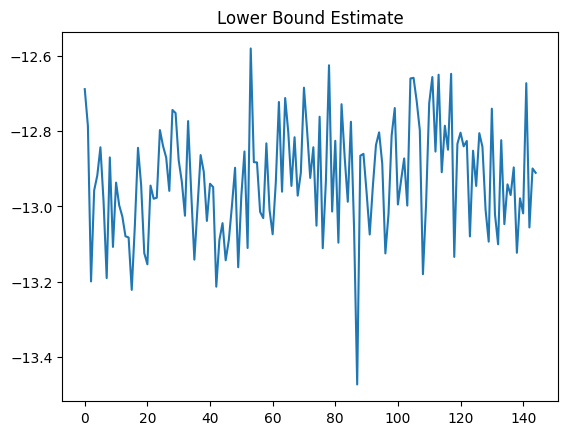

In [ ]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

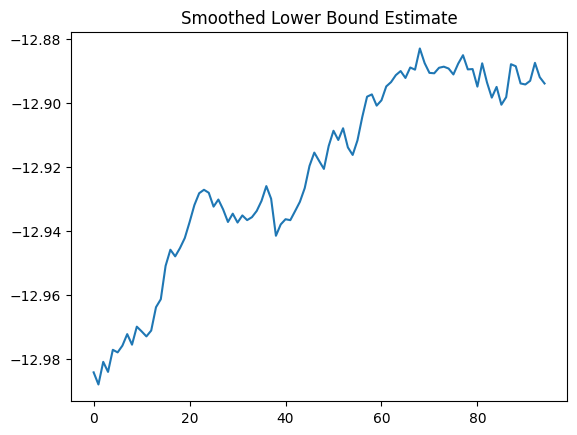

In [ ]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
best_lambda_mu

Array([ 1.2641485 ,  1.121864  , -0.01548264, -0.03683272], dtype=float32)

In [ ]:
best_lambda_l

Array([ 1.0036681e+01, -1.9942826e-02,  3.8977454e-03,  1.8291861e-02,
        1.0023727e+01, -1.7365007e-02, -2.6552984e-02,  9.9140053e+00,
       -5.9761602e-02,  9.9858627e+00], dtype=float32)

In [ ]:
best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta_tilde = random.multivariate_normal(subkeys[10], mean = best_mu, cov = best_Sigma, shape = (1000,))
best_alpha = (2 * jnp.exp(best_theta_tilde[:,0]) + 1.1) / (1 + jnp.exp(best_theta_tilde[:,0]))
best_beta = (jnp.exp(best_theta_tilde[:,1]) - 1) / (jnp.exp(best_theta_tilde[:,1]) + 1)
best_gamma = jnp.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = jnp.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = jnp.mean(best_theta, axis = 1)
posterior_mean_estimate

Array([ 1.8004265 ,  0.508798  ,  0.99393535, -0.04490667], dtype=float32)

In [ ]:
np.linalg.norm(posterior_mean_estimate - true_theta)

0.046162497

In [ ]:
## FIND THE BEST THETA USING VB-NUISSANCE

In [ ]:
num_latent = len(true_theta)

sigma_theta = 10
sigma_latent = 1

In [ ]:
def mean_adjustment_summary_statistics(adjusted_theta, n_samples, n_datasets):
    theta = adjusted_theta[0:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_variance = summary_statistics(theta, n_samples, n_datasets)

    adjusted_sample_mean = sample_mean + jnp.diag(jnp.sqrt(sample_variance)) * Gamma
    return adjusted_sample_mean, sample_variance

In [ ]:
@partial(jit, static_argnames=['sigma_theta','num_coeffs'])
def prior_nuissance(theta, sigma_theta, num_coeffs):
    log_prior = multivariate_normal.logpdf(theta, mean = jnp.array([0] * num_coeffs), cov= sigma_theta * jnp.identity(num_coeffs))
    return log_prior

In [ ]:
def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, actual_summary_statistics, n_samples, num_datasets):
    mean_adjust_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, n_samples, num_datasets)
    adjusted_sample_mean = mean_adjust_ss[0]
    sample_variance = mean_adjust_ss[1]
    # u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= sample_variance)

    diff_mean_s = actual_summary_statistics - adjusted_sample_mean
    part1 = diff_mean_s.T @ jnp.linalg.solve(sample_variance, diff_mean_s)
    u_est_log_likelihood = -1/2 * jnp.linalg.slogdet(sample_variance)[1] -1/2 * part1

    return u_est_log_likelihood

In [ ]:
@jit
def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    nuissance_mean_u_est_log_likelihood = multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

In [ ]:
class GVB_nuissance:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = len(true_theta) # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_tilde_q, mu_q, l_q, c_mu, c_l):
        # Calculate theta from mu, l (lambda)
        alpha_q = (2 * jnp.exp(theta_tilde_q[0]) + 1.1) / (1 + jnp.exp(theta_tilde_q[0]))
        beta_q = (jnp.exp(theta_tilde_q[1]) - 1) / (jnp.exp(theta_tilde_q[1]) + 1)
        gamma_q = jnp.exp(theta_tilde_q[2])
        delta_q = theta_tilde_q[3]
        theta_q = jnp.array([alpha_q, beta_q, gamma_q, delta_q])

        ss_q = summary_statistics(theta_q, n_samples, num_datasets)
        sample_mean_q = ss_q[0]
        sample_variance_q = ss_q[1]
        # Nuissance mean and variance
        mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(sample_variance_q).T @ jnp.linalg.solve(sample_variance_q, jnp.diag(sample_variance_q))
        mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))
        diag_var = jnp.zeros((num_coeffs, num_coeffs)).at[jnp.diag_indices_from(sample_variance_q)].set(jnp.diag(sample_variance_q))
        diff_mean = self.actual_summary_statistics - sample_mean_q
        mean_nuissance_p2 = diag_var @ jnp.linalg.solve(sample_variance_q, diff_mean)
        mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2

        variance_nuissance_q = mean_nuissance_p1

        # Generate Gamma
        Gamma = random.multivariate_normal(key2, mean = mean_nuissance_q, cov = variance_nuissance_q)
        adjusted_theta_q = jnp.concatenate((theta_q, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(theta_q, self.actual_summary_statistics, n_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)

        h_lambda = prior_nuissance(theta_tilde_q, sigma_theta, num_coeffs) + prior_nuissance(Gamma, sigma_latent, num_latent) + llh - fun_log_q(theta_tilde_q, mu_q, l_q) - llh_gamma

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_tilde_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([jnp.log((1.8-1.1)/(2-1.8)),jnp.log((0.5+1)/(1-0.5)),jnp.log(1),0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = jnp.linalg.solve(Sigma_0_inv, jnp.eye(Sigma_0_inv.shape[0]))
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  jnp.linalg.solve(Sigma_q_inv, jnp.eye(Sigma_q_inv.shape[0]))
                l_q_inv =  jnp.linalg.solve(l_q, jnp.eye(l_q.shape[0]))
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))

                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [ ]:
vb_nuissance = GVB_nuissance(400, transformed_actual_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda_mu, best_lambda_l = vb_nuissance.vb_posterior(stop)